In [10]:
import os
import numpy as np
import pandas as pd
import glob, pdb
import pickle
import seaborn as sns
import time
from tqdm import tqdm
from tqdm import trange
import json
import re
import pdb
import math


from matplotlib import pyplot as plt
from matplotlib.pyplot import *
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from numpy.linalg import norm
import scipy
import scipy.io as sio
from scipy.spatial.distance import cosine
import sklearn
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LogisticRegressionCV as LRCV

from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, r2_score, median_absolute_error

import sys
sys.path.append( os.path.abspath(os.path.join('..')) )
from algorithm.model_multiclass_lr import admm as admm3S, admm_classo
from helper.visualization import plot_Q

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def read_data():
    fp='C:/Users/Adrienne/Box Sync/HBN/kinneyac/factor_analysis/data/HBN_w_diagnostic_20210519.csv'
    data=pd.read_csv(fp, dialect='excel')
    
    M_raw=data.iloc[:,22:141]
    C_raw=data.iloc[:,2:4]
    #label_raw=data.iloc[:,13]
    cols=['diag_Depression', 'diag_BPD', 'diag_Schizophrenia_Psychosis',
       'diag_Panic_Agoraphobia_SeparationAnx_SocialAnx',
       'diag_Specific_Phobia', 'diag_GenAnxiety', 'diag_OCD',
       'diag_Encopresis_Enuresis', 'diag_Eating_Disorder', 'diag_ADHD',
       'diag_ODD_ConductDis', 'diag_Tic', 'diag_Suspected_ASD',
       'diag_Substance_Issue', 'diag_PTSD_Trauma', 'diag_Sleep_Probs',
       'diag_Suicidal_SelfHarm_Homicidal']#, 'diag_Mutism']
    #not considering mutism because no positive diagnoses (Logistic regression model doesn't like that)
    label_matrix_raw=data[cols]
    
    M_raw=np.asarray(M_raw)
    label_matrix_raw=np.asarray(label_matrix_raw)
  
    X_train, X_test, y_train, y_test = train_test_split(np.hstack((C_raw,M_raw)),label_matrix_raw,
                                                    test_size=0.33, random_state=42)
    C=X_train[:,:C_raw.shape[1]]
    M=X_train[:,C_raw.shape[1]:]
    label=y_train
    
    C_test=X_test[:,:C_raw.shape[1]]
    M_test=X_test[:,C_raw.shape[1]:]
    label_test=y_test
    return C, M, label, C_test, M_test, label_test


def build_lr_model(W,label,class_weight='balanced'):
    label[label==-1]=0
    log_reg=LRCV(random_state=0).fit(W,label)
    return log_reg

#loadings = subject embeddings
def learn_loadings(C_test, M_test, k, beta, gamma_flag, Q_flag, rho, tau):
    assert(np.sum(np.isnan(C_test)).all() == 0)
    Cmirror_test = np.hstack((C_test, 1-C_test))
    
    mask=(1-1*np.isnan(M_test))
    M_test[np.isnan(M_test)]=0
    
    W_test, _, obj_trend = admm3S(M_test, k, beta, gamma_flag=gamma_flag, Q_flag=Q_flag, C=Cmirror_test, rho=rho, tau=tau, mask=mask, Wconstraint=(True, 1), tol=1e-5)
    return W_test

def score(model, W, label, metrics):
    predictions=model.predict(W)
    
    to_return = list()
    for metric in metrics:
        #print(str(metric).split('<function ')[-1].split(' at')[0] + ': '+ str(metric(label_test, predictions)))
        to_return.append(metric(label, predictions))
        #print(str(metric).split('<function ')[-1].split(' at')[0] + ' no LR: '+ str(metric(label_test, predictions_nolr)))
    return to_return

Loss:   0%|                                                                                    | 0/200 [00:00<?, ?it/s]

0.0


C:\Users\Adrienne\Documents\Projects\NIH\mlt-external\factor_analysis\algorithm\model_multiclass_lr.py:213: RuntimeWarning: invalid value encountered in true_divide
  idx = np.where(np.abs(prev_obj[idx] - obj)/np.abs(obj) > tol)[0]
C:\Users\Adrienne\Documents\Projects\NIH\mlt-external\factor_analysis\algorithm\model_multiclass_lr.py:213: RuntimeWarning: divide by zero encountered in true_divide
  idx = np.where(np.abs(prev_obj[idx] - obj)/np.abs(obj) > tol)[0]
C:\Users\Adrienne\Documents\Projects\NIH\mlt-external\factor_analysis\algorithm\model_multiclass_lr.py:269: RuntimeWarning: invalid value encountered in true_divide
  idx = np.where(np.abs(prev_obj[idx] - obj)/np.abs(obj) > tol)[0]
Loss:   0%|                                                                                    | 0/200 [00:00<?, ?it/s]

Max iteration reached


Loss:   0%|                                                                                    | 0/200 [00:00<?, ?it/s]

Algorithm converged with relative error < 1e-05.
0.1


Loss:   0%|                                                                                    | 0/200 [00:00<?, ?it/s]

Algorithm converged with relative error < 1e-05.


Loss: 5.307e+03:   8%|█████                                                           | 16/200 [00:01<00:17, 10.35it/s]


Algorithm converged with relative error < 1e-05.


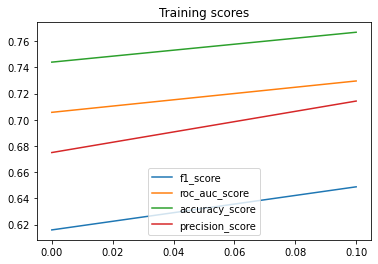

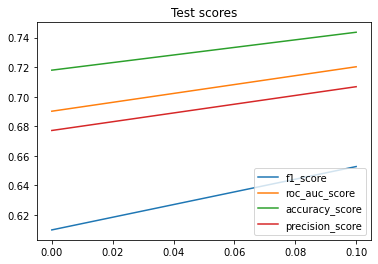

In [18]:
k = 12
beta = 0.5
rho = 3#has to be larger than 1 for convergence
tau = 3#""

gammas=np.arange(0,0.2,0.1)


metrics=[f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, 
             mean_absolute_error, explained_variance_score, mean_squared_error, r2_score, median_absolute_error]
metric_names=["f1_score", "roc_auc_score", "accuracy_score", "precision_score"]#, "recall_score", 
             #"mean_absolute_error", "explained_variance_score", "mean_squared_error", "r2_score", "median_absolute_error"]


train_scores = np.zeros((len(metrics),len(gammas)))
train_scores_nolr = np.zeros((len(metrics),len(gammas)))

test_scores = np.zeros((len(metrics),len(gammas)))
test_scores_nolr = np.zeros((len(metrics),len(gammas)))
for i in range(0,len(gammas)):
    gamma=gammas[i]
    print(gamma)
    C, M, label, C_test, M_test, label_test = read_data()
    
    assert(np.sum(np.isnan(C)).all() == 0)
    Cmirror = np.hstack((C, 1-C))

    mask=(1-1*np.isnan(M))
    M[np.isnan(M)]=0
    
    W, Q, obj_trend = admm3S(M, k, beta, gamma_flag=(True,gamma), label=label, C=Cmirror, rho=rho, tau=tau, mask = mask, Wconstraint=(True, 1), tol=1e-5)
    #W_nolr, Q_nolr, obj_trend_nolr = admm3S(M, k, beta, label=None, C=Cmirror, rho=rho, tau=tau, mask=mask, Wconstraint=(True, 1), tol=1e-5)
    
    single_label = label[:,9]
       
    log_reg = build_lr_model(W, single_label)
    #log_reg_nolr = build_lr_model(W_nolr, label)
    
    train_scores[:,i]=score(log_reg, W, single_label, metrics)
    #train_scores_nolr[:,i]=score(log_reg_nolr, W_nolr, label, metrics)
    
    W_test = learn_loadings(C_test, M_test, k, beta, (True, gamma), (True,Q), rho, tau)
    #W_test_nolr = learn_loadings(C_test, M_test, k, beta, (True, gamma), (True,Q_nolr), rho, tau)
       
    test_scores[:,i]=score(log_reg, W_test, label_test[:,9], metrics)
    #test_scores_nolr[:,i]=score(log_reg_nolr, W_test_nolr, label_test, metrics)

plt.figure(0)
for i in range(0, 4):
    plt.plot(gammas,train_scores[i,:], label=metric_names[i])
#plt.plot(train_scores_nolr[:,:4], label=metric_names)
plt.legend()
plt.title('Training scores')

plt.figure(1)
for i in range(0, 4):
    plt.plot(gammas,test_scores[i,:], label=metric_names[i])
#plt.plot(train_scores_nolr[:,:4], label=metric_names)
plt.legend()
plt.title('Test scores')

plt.show()

Loss:   0%|                                                                                    | 0/200 [00:00<?, ?it/s]

0.0


C:\Users\Adrienne\Documents\Projects\NIH\mlt-external\factor_analysis\algorithm\model_multiclass_lr.py:213: RuntimeWarning: invalid value encountered in true_divide
  idx = np.where(np.abs(prev_obj[idx] - obj)/np.abs(obj) > tol)[0]
C:\Users\Adrienne\Documents\Projects\NIH\mlt-external\factor_analysis\algorithm\model_multiclass_lr.py:213: RuntimeWarning: divide by zero encountered in true_divide
  idx = np.where(np.abs(prev_obj[idx] - obj)/np.abs(obj) > tol)[0]
C:\Users\Adrienne\Documents\Projects\NIH\mlt-external\factor_analysis\algorithm\model_multiclass_lr.py:269: RuntimeWarning: invalid value encountered in true_divide
  idx = np.where(np.abs(prev_obj[idx] - obj)/np.abs(obj) > tol)[0]
Loss: 1.049e+04:   0%|                                                                         | 0/200 [00:00<?, ?it/s]

Max iteration reached


Loss:   0%|                                                                                    | 0/200 [00:00<?, ?it/s]

Algorithm converged with relative error < 1e-05.
0.1


Loss:   0%|                                                                                    | 0/200 [00:00<?, ?it/s]

Algorithm converged with relative error < 1e-05.


Loss: 5.307e+03:   8%|█████                                                           | 16/200 [00:01<00:17, 10.75it/s]


Algorithm converged with relative error < 1e-05.


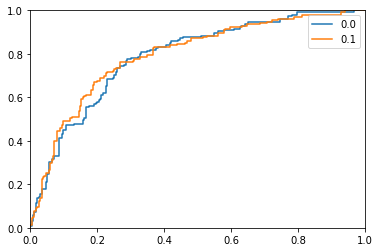

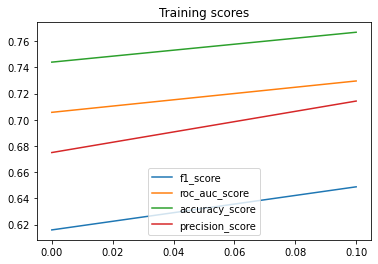

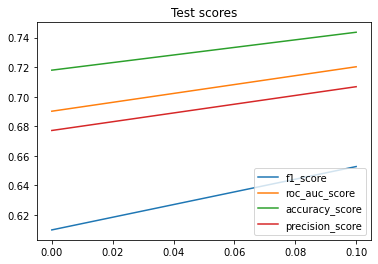

In [19]:
plt.figure(0)

k = 12
beta = 0.5
rho = 3#has to be larger than 1 for convergence
tau = 3#""

gammas=np.arange(0,0.2,0.1)


metrics=[f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, 
             mean_absolute_error, explained_variance_score, mean_squared_error, r2_score, median_absolute_error]
metric_names=["f1_score", "roc_auc_score", "accuracy_score", "precision_score"]#, "recall_score", 
             #"mean_absolute_error", "explained_variance_score", "mean_squared_error", "r2_score", "median_absolute_error"]


train_scores = np.zeros((len(metrics),len(gammas)))
test_scores = np.zeros((len(metrics),len(gammas)))
fprs = list()
tprs = list()

for i in range(0,len(gammas)):
    gamma=gammas[i]
    print(gamma)
    C, M, label, C_test, M_test, label_test = read_data()
    
    assert(np.sum(np.isnan(C)).all() == 0)
    Cmirror = np.hstack((C, 1-C))

    mask=(1-1*np.isnan(M))
    M[np.isnan(M)]=0
    
    W, Q, obj_trend = admm3S(M, k, beta, gamma_flag=(True,gamma), label=label, C=Cmirror, rho=rho, tau=tau, mask = mask, Wconstraint=(True, 1), tol=1e-5)
    #W_nolr, Q_nolr, obj_trend_nolr = admm3S(M, k, beta, label=None, C=Cmirror, rho=rho, tau=tau, mask=mask, Wconstraint=(True, 1), tol=1e-5)
    
    single_label = label[:,9]
       
    log_reg = build_lr_model(W, single_label)
    #log_reg_nolr = build_lr_model(W_nolr, label)
    
    train_scores[:,i]=score(log_reg, W, single_label, metrics)
    #train_scores_nolr[:,i]=score(log_reg_nolr, W_nolr, label, metrics)
    
    W_test = learn_loadings(C_test, M_test, k, beta, (True, gamma), (True,Q), rho, tau)
    #W_test_nolr = learn_loadings(C_test, M_test, k, beta, (True, gamma), (True,Q_nolr), rho, tau)
       
    test_scores[:,i]=score(log_reg, W_test, label_test[:,9], metrics)
    #test_scores_nolr[:,i]=score(log_reg_nolr, W_test_nolr, label_test, metrics)
    
    fpr, tpr, _ = roc_curve(label_test[:,9], log_reg.predict_proba(W_test)[:,1])
    plt.plot(fpr, tpr, label=str(gamma))
    
    
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.figure(1)
for i in range(0, 4):
    plt.plot(gammas,train_scores[i,:], label=metric_names[i])
#plt.plot(train_scores_nolr[:,:4], label=metric_names)
plt.legend()
plt.title('Training scores')

plt.figure(2)
for i in range(0, 4):
    plt.plot(gammas,test_scores[i,:], label=metric_names[i])
#plt.plot(train_scores_nolr[:,:4], label=metric_names)
plt.legend()
plt.title('Test scores')

plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.imshow(W,aspect='auto',vmin=0,vmax=1)

plt.figure(1)
plt.imshow(W_nolr,aspect='auto',vmin=0,vmax=1)

plt.figure(2)
plt.imshow(W_test,aspect='auto',vmin=0,vmax=1)

plt.show()

In [ ]:
#Create simulated data
import copy

def simulation_exp(nrow, ncol, ndict, overlap, density,
                   upperbd=8, lowerbd=0,
                   coh=20, noise=False, SNR=0.8):
    
    D = np.zeros((nrow, ndict))
    for k in range(ndict):
        for j in range(nrow):
            if (j >= (k)*( (nrow//ndict) )) and (j <= (nrow//ndict) + overlap + (k)*((nrow//ndict))):
                D[j,k] = 1* np.random.uniform()
            else:
                D[j,k] = 0
                
    A = np.random.binomial(size=(ndict,ncol), n=1, p=density)
    A = 1.0*(A > 0)
    S = np.random.uniform(low=lowerbd, high=upperbd, size=(ndict,ncol))
    A = A*S
    
    C = np.zeros((nrow, 2))
    C[:nrow//2,0] = 1
    C[nrow//2:,1] = 1
    
#     D[:,0] += C[:,0]*0.3*np.random.binomial(size=(nrow), n=1, p=0.99)
#     D[:,1] += C[:,1]*0.7*np.random.binomial(size=(nrow), n=1, p=0.99)
    
    D[D > 1] = 1
    
#     W2 = C
#     W2 = np.vstack((C[:,0]*np.random.binomial(size=(nrow), n=1, p=0.9),
#                     C[:,1]*np.random.binomial(size=(nrow), n=1, p=0.9))).T

    W2 = np.vstack((C[:,0]*np.random.uniform(size=(nrow), low=0.1, high=0.1),
                    C[:,1]*np.random.uniform(size=(nrow), low=0.1, high=0.1))).T

    A2 = np.vstack((np.ones(ncol)*np.random.uniform(low=lowerbd, high=upperbd*0.5)*np.random.binomial(size=(ncol), n=1, p=0.3),
                    np.ones(ncol)*np.random.uniform(low=lowerbd, high=upperbd*0.5)*np.random.binomial(size=(ncol), n=1, p=0.3)))

    
    P = D@A + W2@A2
    P_clean = copy.deepcopy(P)
    if noise:
        noise_matrix = np.random.choice((0, 1, 2), size=(nrow, ncol), p=[SNR, (1 - SNR) / 2., (1 - SNR) / 2.])
        P[noise_matrix == 1] = 1
        P[noise_matrix == 2] = 2
        
#         P = np.maximum(P, noise_matrix)
        
        
        fig, ax = pyplot.subplots(figsize=(10,3))
        sns.heatmap(noise_matrix.T, ax=ax, cmap="Blues", cbar=False)
        ax.set_title('Noise matrix, SNR = {}'.format(SNR))
        ax.set_xticks([])
        ax.set_yticks([])
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 1.5, top - 0.5)

    true_W = np.hstack((D, W2))
    true_Q = np.vstack((A, A2)).T
    

    fig = pyplot.figure(figsize=(14,2))
    ax_list = [fig.add_subplot(1,2,i+1) for i in range(2)]

    sns.heatmap(true_W.T, ax=ax_list[0], cmap="Blues", cbar=False)
    ax_list[0].set_title('True W, range:[{:.3f}, {:.3f}]'.format(np.min(true_W), np.max(true_W)))
    ax_list[0].set_xticks([])
    ax_list[0].set_yticks([])
    bottom, top = ax_list[0].get_ylim()
    ax_list[0].set_ylim(bottom + 1.5, top - 0.5)
    
    sns.heatmap(true_Q.T, ax=ax_list[1], cmap="Blues", cbar=False)
    ax_list[1].set_title('True Q, range:[{:.3f}, {:.3f}]'.format(np.min(true_Q), np.max(true_Q)))
    ax_list[1].set_xticks([])
    ax_list[1].set_yticks([])
    bottom, top = ax_list[1].get_ylim()
    ax_list[1].set_ylim(bottom + 1.5, top - 0.5)
 
    pyplot.tight_layout()
    pyplot.show()
    
        
    return P, true_W, true_Q, C, P_clean
        

In [ ]:
M, true_W, true_Q, C, M_clean = simulation_exp(200, 30, 10, 5, 0.3, noise=True, SNR=0.95)

_, s, _ = np.linalg.svd(M)
_, s_clean, _ = np.linalg.svd(M_clean)

In [ ]:
print('Range of data matrix M: [{}, {}]'.format(np.min(M), np.max(M)))

In [ ]:
fig = pyplot.figure(figsize=(14,4))
ax_list = [fig.add_subplot(1,3,i+1) for i in range(3)]
ax_list[0].plot(np.linspace(1, s.shape[0], s.shape[0]), s, marker='o',label='Polluted $\sigma$')
ax_list[0].plot(np.linspace(1, s_clean.shape[0], s_clean.shape[0]), s_clean, marker='o',c='r',label='True $\sigma$')
ax_list[0].set_title('Dimension: {}'.format(12))
ax_list[0].grid(alpha=0.5)
ax_list[0].yaxis.set_major_locator(MaxNLocator(integer=True))
ax_list[0].vlines(12, -10, np.max(s), color='k')
ax_list[0].legend()

sns.heatmap(M, ax=ax_list[1], cmap="Blues", cbar = False)
bottom, top = ax_list[1].get_ylim()
ax_list[1].set_ylim(bottom + 0.5, top - 0.5)
ax_list[1].set_title('{}x{} Input Matrix,\n sparsity {:.4f}, max {:.4f}'
                     .format(M.shape[0], M.shape[1], np.sum(M != 0)/(M.shape[0]*M.shape[1]), np.max(M)))

sns.heatmap(M_clean, ax=ax_list[2], cmap="Blues", cbar = False)
bottom, top = ax_list[2].get_ylim()
ax_list[2].set_ylim(bottom + 0.5, top - 0.5)
ax_list[2].set_title('{}x{} Noiseless Input Matrix,\n sparsity {:.4f}, max {:.4f}'
                     .format(M_clean.shape[0], M_clean.shape[1],
                             np.sum(M_clean != 0)/(M_clean.shape[0]*M_clean.shape[1]), np.max(M_clean)))

pyplot.tight_layout()
pyplot.show()

In [ ]:
def greedy_sort(W, true_W):
    bestmatch_ordering = np.array([])
    bestmatch_cor = np.array([])
    tempidx = np.arange(W.shape[1])
    temp_W = W
    match_W = np.zeros_like(W)
    
    for k in range(W.shape[1]):
        pc = np.array([])
        pcorrelation=np.array([])

        if k < true_W.shape[1]:

            for d in range(temp_W.shape[1]):
                pc = np.append(pc, 1 - cosine(true_W[:,k], temp_W[:,d]))
            sort_idx = np.argsort(-pc)
            match_W[:,k] = temp_W[:, sort_idx[0]]
            bestmatch_ordering = np.append(bestmatch_ordering, tempidx[sort_idx[0]])
            bestmatch_cor = np.append(bestmatch_cor, pc[sort_idx[0]])

            temp_W = np.delete(temp_W, sort_idx[0], axis=1)
            tempidx = np.delete(tempidx, sort_idx[0])

        else:
            if temp_W.shape[1] > 0:
                sort_idx = np.argsort(-np.max(temp_W,axis=0))
                temp_W = temp_W[:,sort_idx]
                match_W[:,k] = temp_W[:,0]
                temp_W = np.delete(temp_W, sort_idx[0], axis=1)
                
    return match_W, bestmatch_ordering, bestmatch_cor

In [ ]:
Wfull = np.hstack((W, C))
Qfull = Q

match_W, orders, corr = greedy_sort(Wfull, true_W)

fig = pyplot.figure(figsize=(14,4))
ax_list = [fig.add_subplot(2,2,i+1) for i in range(4)]

sns.heatmap(true_W.T, ax=ax_list[0], cmap="Blues", cbar=False)
ax_list[0].set_title('True W, range:[{:.3f}, {:.3f}]'.format(np.min(true_W), np.max(true_W)))
ax_list[0].set_xticks([])
ax_list[0].set_yticks([])
bottom, top = ax_list[0].get_ylim()
ax_list[0].set_ylim(bottom + 1.5, top - 0.5)
sns.heatmap(match_W.T, ax=ax_list[2], cmap="Blues", cbar=False)
ax_list[2].set_title('W (up to permutation), range:[{:.3f}, {:.3f}]'.format(np.min(Wfull), np.max(Wfull)))
ax_list[2].set_xticks([])
ax_list[2].set_yticks([])
bottom, top = ax_list[2].get_ylim()
ax_list[2].set_ylim(bottom + 1.5, top - 0.5)
sns.heatmap(true_Q.T, ax=ax_list[1], cmap="Blues", cbar=False)
ax_list[1].set_title('True Q, range:[{:.3f}, {:.3f}]'.format(np.min(true_Q), np.max(true_Q)))
ax_list[1].set_xticks([])
ax_list[1].set_yticks([])
bottom, top = ax_list[1].get_ylim()
ax_list[1].set_ylim(bottom + 1.5, top - 0.5)
sns.heatmap(Qfull[:, orders.astype('int')].T, ax=ax_list[3], cmap="Blues", cbar=False)
ax_list[3].set_title('Q (up to permutation), range:[{:.3f}, {:.3f}]'.format(np.min(Qfull), np.max(Qfull)))
ax_list[3].set_xticks([])
ax_list[3].set_yticks([])
bottom, top = ax_list[3].get_ylim()
ax_list[3].set_ylim(bottom + 1.5, top - 0.5)
pyplot.tight_layout()
pyplot.show()

fig = pyplot.figure(figsize=(14,3))
ax_list = [fig.add_subplot(1,2,i+1) for i in range(2)]
ax_list[0].set_xlim([1, len(obj_trend)+1])
ax_list[0].plot(np.arange(len(obj_trend))+1, obj_trend)
ax_list[0].set_yscale('log')
ax_list[0].grid()
message = '$WQ^T$ range: [{:.3f}, {:.3f}]'.format(np.min(np.hstack((W, Cmirror))@(Qfull.T)), np.max(np.hstack((W, Cmirror))@(Qfull.T)))
ax_list[0].set_title(message)
ax_list[0].set_xlabel('Iterations')
ax_list[0].set_ylabel('Loss', fontsize=14)

scores = sklearn.metrics.explained_variance_score(M, np.hstack((W, Cmirror))@Qfull.T, multioutput='raw_values')
ax_list[1].bar(np.arange(scores.shape[0]), scores)
ax_list[1].set_xlabel('Feature dimension')
ax_list[1].set_title('Explained Variance Score')
pyplot.tight_layout()
pyplot.show()
